In [1]:
%load_ext autoreload
%autoreload 2

# Look at the impact of the association

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
proj = ccrs.PlateCarree()

#External functions 
import fct.fct_link_storm_claim as fct_link_storm_claim
import fct.preprocess_sinclim as preprocess_sinclim
import fct.fct_plot_claims as fct_plot_claims
from fct.paths import *

path_save_fig = PATH_FIGURE+"association_impact/"

In [3]:
period = "1979-2024WIN"
df_info_storm                       = pd.read_csv(PATH_TRACKS+"tracks_ALL_24h_"+period+"_info.csv", encoding='utf-8')
df_info_storm['storm_landing_date'] = pd.to_datetime(df_info_storm['storm_landing_date'])
df_storm                            = pd.read_csv(PATH_TRACKS+"tracks_ALL_24h_"+period+".csv", encoding='utf-8')
print(f"{df_info_storm.storm_id.nunique()} number of storms")

df_info_storm_FR                       = pd.read_csv(PATH_TRACKS+"tracks_FR_ALL_24h_"+period+"_info.csv", encoding='utf-8')
df_info_storm_FR['storm_landing_date'] = pd.to_datetime(df_info_storm_FR['storm_landing_date'])
df_storm_FR                            = pd.read_csv(PATH_TRACKS+"tracks_FR_ALL_24h_"+period+".csv", encoding='utf-8')
print(f"{df_info_storm_FR.storm_id.nunique()} number of storms - FR")

# df_info_storm_SSI = pd.read_csv(PATH_TRACKS+"tracks_FR_ALL_24h_1979-2024WIN_info_SSI-wgust-q98_r1300.csv", encoding="utf-8")
# df_info_storm_SSI = df_info_storm_SSI.rename(columns={'SSI_FRA_wgust_q98' : "SSI_FRA"})
# df_info_storm = pd.merge(df_info_storm, df_info_storm_SSI[['storm_id', 'SSI_FRA']], on='storm_id')

########## IMPACT DATA 
window              = 'd-3_d+3'
min_claim           = 50
method              = 'wgust'
r_sinclim           = 1300
r_varying           = False
sinclim_version     = "v2.2"
sinclim_date        = "v200126"
sinclim_peril       = "storm" #"storm" # "storm_extended"

sinclim = preprocess_sinclim.open_sinclim_associated(PATH_GENERALI, sinclim_version, sinclim_peril, sinclim_date, window, min_claim, method, "1997-2024", r_sinclim, False)
stormi_impact = sinclim.storm_id.unique()

df_info_storm_impact = df_info_storm.loc[df_info_storm.storm_id.isin(stormi_impact)]
df_storm_impact      = df_storm.loc[df_storm.storm_id.isin(stormi_impact)]
print(f"{df_info_storm_impact.storm_id.nunique()} storms with impact")

#Add storm_landing date and SSI
sinclim = pd.merge(sinclim, df_info_storm_impact, on='storm_id', how='left')

#Load clusters 
windi      = 96
r_cluster  = 700

r_part_sinclim = f"r-varying" if r_varying else f"r{r_sinclim}"
r_part_clust = f"_r{r_cluster}" if r_cluster is not None else ""
fname_cluster = f"tracks_FR_ALL_24h_impact_{sinclim_version}_{sinclim_peril}_{window}-unique-{method}_min{min_claim}_{r_part_sinclim}_{sinclim_date}_clust-mult-2storms-{windi}h{r_part_clust}_{period}"
df_storm_cluster_test                            = pd.read_csv(PATH_TRACKS+fname_cluster+".csv", encoding='utf-8')
df_info_mult_cluster_test                       = pd.read_csv(PATH_TRACKS+fname_cluster+"_info.csv", encoding='utf-8')
df_info_mult_cluster_test['storm_landing_date'] = pd.to_datetime(df_info_mult_cluster_test['storm_landing_date'])

9881 number of storms
4439 number of storms - FR
322 storms with impact


## On the date of declaration

In [4]:
# Compute days difference (if not already done)
sinclim['days_diff_abs'] = np.abs((sinclim['dat_sin'] - sinclim['storm_landing_date']).dt.days)
sinclim['hours_diff_abs'] = np.abs((sinclim['dat_sin'] - sinclim['storm_landing_date']).dt.total_seconds() / 3600)

In [5]:
len(sinclim.loc[sinclim.hours_diff_abs <= 24])/len(sinclim)

0.7761470581842683

In [6]:
0.5+0.37+0.07+0.02

0.96

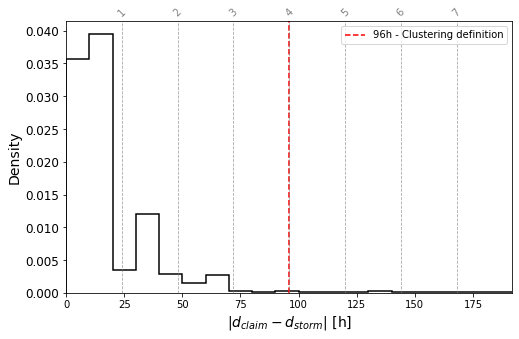

In [7]:
# Define bins for each day from -10 to 10
nb_max_days = 8
fontsize=14
# bins = np.arange(0, nb_max_days+1, 1)
bins = np.arange(0, 24*(nb_max_days+1), 10)

fig, ax = plt.subplots(figsize=(8, 5))
plt.hist(
    sinclim['hours_diff_abs'],
    bins=bins,
    density=True,
    histtype='step',
    linewidth=1.5, 
    color="black"
)
#plt.xlabel('Days between claim and storm landing')
plt.xlabel(r"$|d_{claim} - d_{storm}|$ [h]", fontsize=fontsize)
plt.ylabel('Density', fontsize=fontsize)
# plt.title('Distribution of Claim Date vs Storm Landing', fontsize=fontsize+2)
plt.axvline(96, color='red', linestyle='--', label='96h - Clustering definition')
plt.xlim(0, 24*nb_max_days)
# plt.xticks(range(0, nb_max_days+1), fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-2)
plt.legend()

# --- Add thin vertical lines every 24h ---
# max_duration = max(s["duration_hours"].max() for s in storm_stats) # get the max value

for day in range(1, nb_max_days): # +2 to ensure the last line is included
    ax.axvline(x=24*day, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)

# --- Label the day numbers on top
for day in range(1, nb_max_days):
    ax.text(24*day, ax.get_ylim()[1]*1.01, f"{day}", rotation=45, ha='center', va='bottom', fontsize=10, color='gray')

fig.savefig(path_save_fig+f"Absolute_difference_dates-{method}-{window}-min{min_claim}_r{r_sinclim}.png", 
            transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+f"Absolute_difference_dates-{method}-{window}-min{min_claim}_r{r_sinclim}.pdf", 
            format="pdf", transparent=True, bbox_inches='tight', dpi=300)